## DEPENDENCIES

In [3]:
from torchvision.models import resnet101, ResNet101_Weights
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset
from torchmetrics import ConfusionMatrix
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchinfo import summary
from ultralytics import YOLO
from pathlib import Path
from PIL import Image
from torch import nn
import ultralytics
import numpy as np
import torchvision
import random
import torch
import cv2
import os

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## FUNCTIONS

In [35]:
# Model training function
def train_step(model: torchvision.models, 
                dataloader: torch.utils.data.dataloader.DataLoader, 
                loss_fn: torch.nn.modules.loss, 
                optimizer: torch.optim) -> int:
    # Set model to training mode
    model.train()
    # Initiate loss and accuracy
    train_loss = 0
    train_acc = 0
    # Loop through training data batches
    for (X, y) in dataloader:
        X = X.permute(0, 3, 1, 2)
        y = y.long()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss = train_loss + loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Gets model prediction
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


# Model testing function
def test_step(model: torchvision.models, 
            dataloader: torch.utils.data.dataloader.DataLoader, 
            loss_fn: torch.nn.modules.loss) -> int:
    # Set model to evaluation  mode
    model.eval()
    # Initiate loss and accuracy
    test_loss = 0
    test_acc = 0
    # Loop through testing or validation data batches
    with torch.inference_mode():
        for (X, y) in dataloader:
            X = X.permute(0, 3, 1, 2)
            y = y.long()
            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            # Gets model prediction
            y_pred_class = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item()/len(y_logits)

    # adjust metrics
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [37]:
# Loss curve plot
def plot_tl_loss_curves(results: dict) -> None:
    # Print out the best accuracy of this training set
    print(f'Best test accuracy: {max(results['test_acc']):.2f}%')

    loss = results['train_loss']
    test_loss = results['test_loss']
    train_accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(12, 5))
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    listOf_Xticks = np.arange(0, len(results['test_loss']), 2)
    plt.xticks(listOf_Xticks)
    plt.xlim(0, (len(results['test_loss']) - 1))
    plt.grid(True)
    plt.legend()
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.xticks(listOf_Xticks)
    plt.xlim(0, (len(results['test_loss']) - 1))
    plt.grid(True)
    plt.legend()

In [38]:
# Transfer learning model training function
def train_tl_model(lr: float, 
                    epochs: int, 
                    train_dataset: torch.utils.data.dataloader.DataLoader, 
                    val_dataset: torch.utils.data.dataloader.DataLoader, 
                    classes: list[str], 
                    results: list[dict], 
                    model: torchvision.models, 
                    loss_function: torch.nn.modules.loss, 
                    classifier=None) -> torchvision.models:  
    # Initiate dictionary to store training and validation loss and accuracy
    res = {'learning_rate': [],
            'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': []}

    output_shape = len(classes)
    # Recreate the classifier layer
    if classifier:
        model.fc = classifier
    else:
        model.fc = torch.nn.Sequential(
                torch.nn.Dropout(p=0.2, inplace=True), 
                torch.nn.Linear(in_features=2048, 
                                out_features=output_shape, # Same number of output units as our number of classes
                                bias=True))
    
    loss_fn = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Print out log of the model training
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataset, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, val_dataset, loss_fn)
        print(f'Epoch: {epoch:02d} | Train loss: {train_loss:.4f}, Train acc: {train_acc:.2f}% | \
Test loss: {test_loss:.4f}, Test acc: {test_acc:.2f}%')
        res['train_loss'].append(train_loss)
        res['train_acc'].append(train_acc)
        res['test_loss'].append(test_loss)
        res['test_acc'].append(test_acc)
    res['learning_rate'].append(lr)
    results.append(res)

    return model

In [46]:
# Plot original, masked and transformed images
def plot_masked_image(image_paths: list[str], 
                    model: ultralytics.models.yolo.model.YOLO, 
                    n: int, 
                    transform: torchvision.transforms.transforms.Compose) -> None:
    # Gets 'n' amount of random image paths
    random_image_paths = random.sample(image_paths, k=n)
    tensor_imgs = []
    # Loops through the randomly selected images
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
            ax[0].imshow(f)
            ax[0].set_title('Original Image', fontsize=20)
            ax[0].axis(False)

            # Transform and plot target image
            results = model(image_path)
            original_image = cv2.imread(image_path)
            h, w = original_image.shape[:2]
            mask = np.zeros((h, w), dtype=np.uint8)
            # Extract segmentation masks from results
            for result in results:
                # Get segmentation masks
                if result.masks is not None:
                    # For each detected object
                    for seg in result.masks.xy:
                        # Convert segmentation points to integer array
                        segment = np.array(seg, dtype=np.int32)
                        # Draw filled polygon on the mask
                        cv2.fillPoly(mask, [segment], 255)  # 255 for white

            # Apply the mask to extract the subjects
            masked_image = cv2.bitwise_and(original_image, original_image, mask=mask)

            # Convert mask to 3-channel for subtraction
            inverted_mask = cv2.bitwise_not(mask)

            # Create colored background
            background = np.ones_like(original_image) * [0, 0, 0]

            # Apply inverted mask to background
            background_masked = cv2.bitwise_and(background, background, mask=inverted_mask)

            # Make sure both images have the same data type
            masked_image = masked_image.astype(np.uint8)
            background_masked = background_masked.astype(np.uint8)

            # Now add them together
            final_image = cv2.add(masked_image, background_masked)
            final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
            ax[1].imshow(final_image)
            ax[1].set_title('Masked Image', fontsize=20)
            ax[1].axis('off')

            # transform to tensor
            pil_masked_image = Image.fromarray(final_image)
            transformed_image = transform(pil_masked_image).permute(1, 2, 0)
            tensor_imgs.append(transformed_image)

            ax[2].imshow(transformed_image)
            ax[2].set_title('Tensor Image', fontsize=20)
            ax[2].axis('off')

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=20)

In [19]:
# Mask verification
def verify_masks(image_paths: list[str], 
                model: ultralytics.models.yolo.model.YOLO) -> list:
    data_transform = transforms.Compose([
    # Resize the image to 224x224
    transforms.Resize(size=(224, 224)),
    # Turn the image into a torch tensor
    transforms.ToTensor()
    ])

    masked_images = []
    empty_masked_imgs = []

    for idx, image_path in enumerate(image_paths):
        # Transform and plot target image
        results = model(image_path)
        original_image = cv2.imread(image_path)
        h, w = original_image.shape[:2]
        mask = np.zeros((h, w), dtype=np.uint8)

        if len(results) == 0:
            empty_masked_imgs.append(image_path)
        else:
            # Extract segmentation masks from results
            for result in results:
                # Get segmentation masks
                if result.masks is not None:
                    # For each detected object
                    for seg in result.masks.xy:
                        # Convert segmentation points to integer array
                        segment = np.array(seg, dtype=np.int32)
                        # Draw filled polygon on the mask
                        cv2.fillPoly(mask, [segment], 255)  # 255 for white

            # Apply the mask to extract the subjects
            masked_image = cv2.bitwise_and(original_image, original_image, mask=mask)

            # Convert mask to 3-channel for subtraction
            inverted_mask = cv2.bitwise_not(mask)
            inverted_mask_3ch = cv2.merge([inverted_mask, inverted_mask, inverted_mask])

            # Create colored background
            background = np.ones_like(original_image) * [0, 0, 0]  # Blue background

            # Apply inverted mask to background
            background_masked = cv2.bitwise_and(background, background, mask=inverted_mask)

            # Make sure both images have the same data type
            masked_image = masked_image.astype(np.uint8)
            background_masked = background_masked.astype(np.uint8)

            # Now add them together
            final_image = cv2.add(masked_image, background_masked)
            final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
            pil_masked_image = Image.fromarray(final_image)
            transformed_image = data_transform(pil_masked_image).permute(1, 2, 0)
            masked_images.append(transformed_image)

        # image mask detection validation
        randomlist = random.sample(range(0, 224), 45)
        zeros = torch.zeros([224, 3])
        count = 0
        for idx, masked_img in enumerate(masked_images):
            for i in randomlist:
                if torch.all(masked_img[i] == zeros).item():
                    count += 1

            if count == len(randomlist):
                empty_masked_imgs.append(idx)
            count = 0

    empty_masked_imgs = list(set(empty_masked_imgs))

    print(f'\n\nThere are {len(empty_masked_imgs)} images without a correct mask!')
    return empty_masked_imgs, masked_images

In [39]:
# Generate extra tensors for training
def generate_extra_tensors(original_tensors_list: list[torch.Tensor], 
                            num: int, 
                            size: int) -> torch.tensor:
    # Flips the image horizontally
    ver_data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
    ])

    # Flips the image vertically
    hor_data_transform = transforms.Compose([
        transforms.RandomVerticalFlip(p=1),
    ])

    # Doubles the number of original images
    transformed_imgs = torch.zeros(len(original_tensors_list), size, size, 3)
    # Generate vertically flipped tensors
    for i in range(len(original_tensors_list)):
        transformed_imgs[i] = ver_data_transform(original_tensors_list[i])
    # Stack original and new tensors
    starter_tensor = torch.concat(
        (torch.unsqueeze(original_tensors_list[0], dim=0), torch.unsqueeze(original_tensors_list[1], dim=0)), 
        dim=0
    )
    for tensor in original_tensors_list[2:]:
        starter_tensor = torch.concat((starter_tensor, torch.unsqueeze(tensor, dim=0)), dim=0)

    # Concatenating the tensors
    doubled_tensors = torch.concat((transformed_imgs, starter_tensor), dim=0)

    # Quadruples the number of images
    continued_transformed_images = torch.zeros(doubled_tensors.shape[0], size, size, 3)
    # Generate horizontally flipped tensors
    for i in range(doubled_tensors.shape[0]):
        continued_transformed_images[i] = hor_data_transform(doubled_tensors[i])
    # Stack original and new tensors
    quadrupled_tensors = torch.concat((continued_transformed_images, doubled_tensors), dim=0)
    # Return tensors as necessary
    if num == 1:
        return doubled_tensors
    elif num == 2:
        return quadrupled_tensors

In [48]:
# Generate stratified split for training and testing data
def create_stratified_split(y_tensor: torch.Tensor,
                            test_size=0.15, # 15% of the dataset
                            random_state=42) -> list[int]:
    # Convert tensors to numpy for sklearn compatibility
    y_np = y_tensor.numpy() if y_tensor.is_cuda == False else y_tensor.cpu().numpy()
    # Get stratified train/test indices
    train_indices, test_indices = train_test_split(
        np.arange(len(y_np)),
        test_size=test_size,
        random_state=random_state,
        stratify=y_np  # This ensures balanced classes in both splits
    )

    return train_indices, test_indices

In [40]:
# Function to get the target model accuracy 
def get_model_accuracy(model: torchvision.models, 
                        test_data: torch.utils.data.dataloader.DataLoader, 
                        class_names: list[str]) -> None:
    y_preds = []

    model.eval()
    with torch.inference_mode():
        for X, y in test_data.dataset:
            logits = model(X.unsqueeze(dim=0).permute(0, 3, 1, 2))
            pred_probs = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(pred_probs, dim=1)
            y_preds.append(pred_label)

    y_pred_tensor = torch.cat(y_preds)
    confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
    confmat_tensor = confmat(preds=y_pred_tensor,
                            target=test_data.dataset[:][1])

    confusion_matrix = confmat_tensor.numpy()

    # Calculate precision for each class
    precision_per_class = []
    for i in range(len(class_names)):
        tp = confusion_matrix[i, i]
        fp = sum(confusion_matrix[:, i]) - tp
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        precision_per_class.append(precision)

    # Macro-average precision
    macro_average_precision = np.mean(precision_per_class)

    # Weighted-average precision
    support = confusion_matrix.sum(axis=1)
    weighted_average_precision = np.sum(np.array(precision_per_class) * support) / np.sum(support)

    print(f"Precision per class:")
    for idx, name in enumerate(class_names):
        print(f'{name}: {(precision_per_class[idx] * 100):.2f}%')
    print(f"Macro-average precision: {(macro_average_precision * 100):.2f}%")
    print(f"Weighted-average precision: {(weighted_average_precision * 100):.2f}%")

In [50]:
# Function to evaluate the model by predicting random test images
def eval_model(test_data: torch.utils.data.dataloader.DataLoader, 
                model: torchvision.models, 
                class_names: list[str]) -> list[dict]:
    n_cols = 4
    num_rows = 4
    img_tensors = []
    img_labels = []
    model.eval()

    # Gets 16 random test images
    for i in range(num_rows * n_cols):
        idx = random.randint(0, len(test_data.dataset[:][0]))
        img_tensors.append(test_data.dataset[:][0][idx])
        img_labels.append(test_data.dataset[:][1][idx])
    
    # Store predictions
    preds = []

    # Makes predictions on the selected images
    for i in range(len(img_tensors)):
        logits = model(img_tensors[i].unsqueeze(dim=0).permute(0, 3, 1, 2))
        pred_probs = torch.softmax(logits, dim=1)
        pred_label = torch.argmax(pred_probs, dim=1)
        # Find prediction label
        pred_label = class_names[pred_label]
        # Find real label
        true_label = class_names[int(img_labels[i].item())]
        #
        preds.append({
            "prediction": pred_label,
            "actual": true_label
        })
    
    fig, ax = plt.subplots(nrows=num_rows, ncols=n_cols, figsize=(18, 18))
    # titles
    titles = []
    for item in preds:
        if item['prediction'] == item['actual']:
            titles.append((
                f'Pred: {item['prediction']} | True: {item['actual']}', 'g'
            ))
        else:
            titles.append((
                f'Pred: {item['prediction']} | True: {item['actual']}', 'r'
            ))

    for i in range(num_rows):
        k = 4 * i
        for j in range(n_cols):
            ax[i][j].imshow(img_tensors[j+k])
            ax[i][j].set_title(titles[j+k][0], fontsize=15, c=titles[j+k][1])
            ax[i][j].axis(False)

    fig.suptitle("Class:", fontsize=20)
    return preds

In [51]:
# Function to generate a confusion matrix of the target model
def generate_confmat(model: torchvision.models, 
                    data: torch.utils.data.dataloader.DataLoader, 
                    class_names: list[str]) -> None:
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in data.dataset:
            #
            # X = X.permute(0, 3, 1, 2)
            # y = y.long()
            logits = model(X.unsqueeze(dim=0).permute(0, 3, 1, 2))
            # #
            # logits = model(X.unsqueeze(dim=0))
            pred_probs = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(pred_probs, dim=1)
            y_preds.append(pred_label)

    y_pred_tensor = torch.cat(y_preds)
    confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
    confmat_tensor = confmat(preds=y_pred_tensor,
                            target=data.dataset[:][1])

    return plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7))

## EDA

In [4]:
# initiate YOLO model
model = YOLO("yolov8m-seg.pt")

# Get all image paths
image_path = Path('CW_data/')

yuki_image_path_list = list(image_path.glob('Yuki_testing_training/*.jpg'))
sekai_image_path_list = list(image_path.glob('Sekai_testing_training/*.jpg'))
emiko_image_path_list = list(image_path.glob('Emiko_testing_training/*.jpg'))
fox_image_path_list = list(image_path.glob('Fox_testing_training/*.jpg'))
stranger_image_path_list = list(image_path.glob('Cats_testing_training/*.jpg'))

In [9]:
collections = {
    'Yuki': yuki_image_path_list,
    'Sekai': sekai_image_path_list,
    'Emiko': emiko_image_path_list,
    'Fox': fox_image_path_list,
    'Stranger': stranger_image_path_list
}

# Print out the total amount of pictures per class
for collection in collections:
    print(f'The class {collection} has {len(collections[collection])} pictures')

The class Yuki has 222 pictures
The class Sekai has 76 pictures
The class Emiko has 160 pictures
The class Fox has 138 pictures
The class Stranger has 149 pictures



image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Cats_testing_training/514.jpg: 512x640 1 cat, 315.8ms
Speed: 2.2ms preprocess, 315.8ms inference, 4.2ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Cats_testing_training/554.jpg: 640x576 1 cat, 291.3ms
Speed: 2.7ms preprocess, 291.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Cats_testing_training/117.jpg: 608x640 1 cat, 298.0ms
Speed: 1.5ms preprocess, 298.0ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


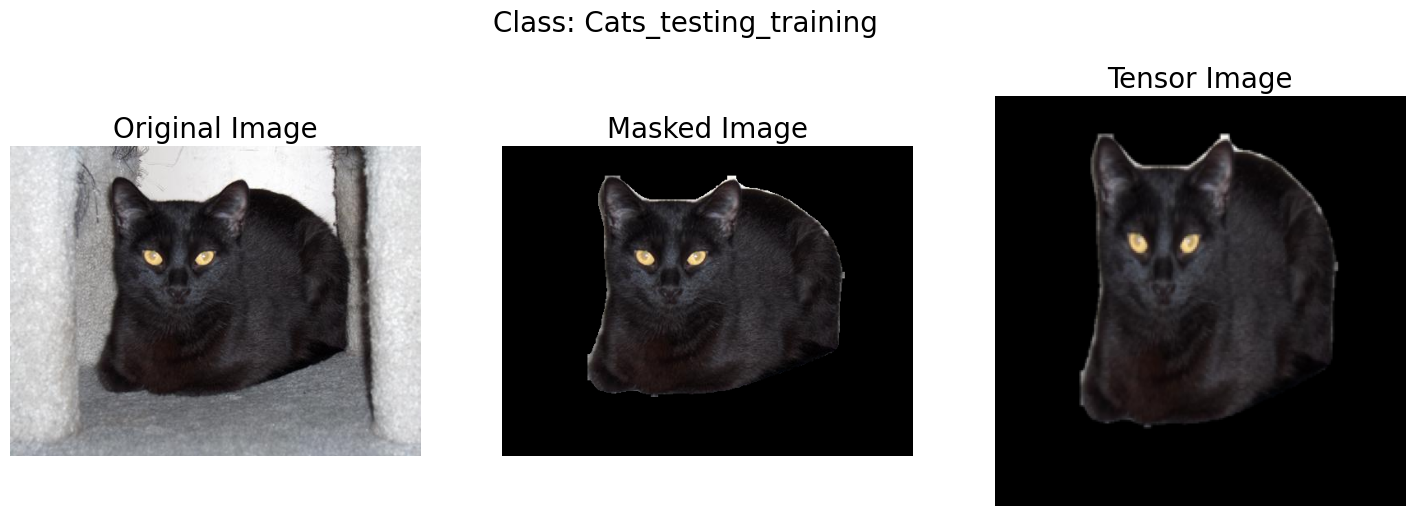

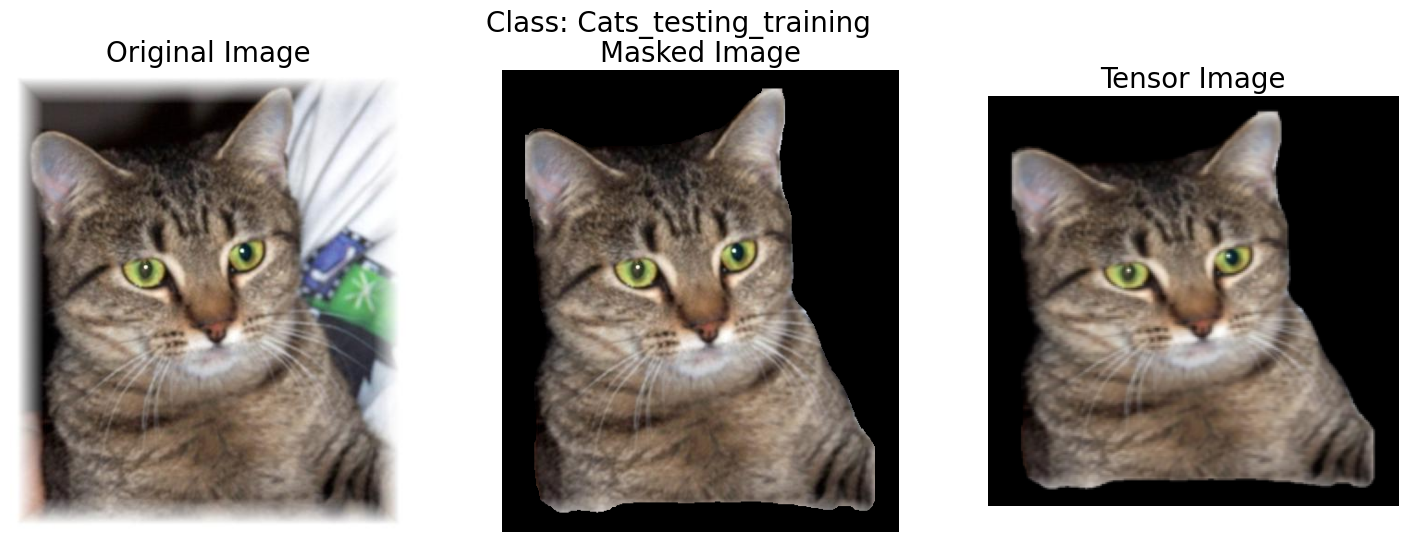

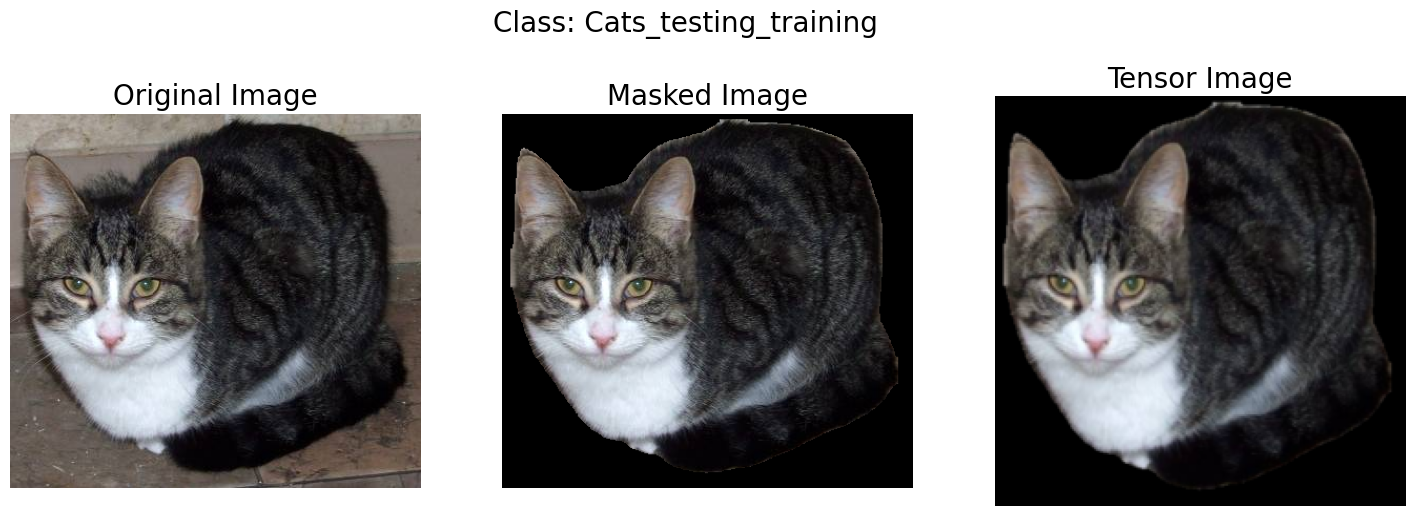

In [15]:
data_transform = transforms.Compose([
    # Resize the image to 224x224
    transforms.Resize(size=(224, 224)),
    # Turn the image into a torch tensor
    transforms.ToTensor()
])

# Plot 3 different random images from the stranger class
plot_masked_image(stranger_image_path_list, model, 3, data_transform)

### Converting images into tensors

In [20]:
# Check for empty masks
yuki_missing_masks, yuki_masked_tensor_images = verify_masks(yuki_image_path_list, model)


image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Yuki_testing_training/PXL_20250414_194709052.jpg: 640x640 1 cat, 330.4ms
Speed: 3.3ms preprocess, 330.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Yuki_testing_training/PXL_20250414_194654341.jpg: 640x640 1 person, 1 cat, 1 tv, 319.1ms
Speed: 1.8ms preprocess, 319.1ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Yuki_testing_training/PXL_20250225_161510527.jpg: 640x640 1 cat, 317.4ms
Speed: 1.9ms preprocess, 317.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Yuki_testing_training/PXL_20250414_194941779.jpg: 640x640 1 person, 1 cat, 1 chair, 1 potted plant, 316.3ms
Speed: 2.0ms prepro

In [21]:
# Check for empty masks
sekai_missing_masks, sekai_masked_tensor_images = verify_masks(sekai_image_path_list, model)


image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Sekai_testing_training/PXL_20250415_184831798.jpg: 640x640 1 cat, 330.6ms
Speed: 2.5ms preprocess, 330.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Sekai_testing_training/PXL_20250415_131028275.jpg: 640x640 1 cat, 301.5ms
Speed: 1.7ms preprocess, 301.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Sekai_testing_training/PXL_20250415_184743139.jpg: 640x640 1 cat, 297.0ms
Speed: 2.0ms preprocess, 297.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Sekai_testing_training/PXL_20250415_131030214.jpg: 640x640 1 cat, 314.8ms
Speed: 1.8ms preprocess, 314.8ms inference, 1.5ms postprocess per 

In [22]:
# Check for empty masks
emiko_missing_masks, emiko_masked_tensor_images = verify_masks(emiko_image_path_list, model)


image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Emiko_testing_training/PXL_20250411_210511062.jpg: 640x640 1 cat, 311.7ms
Speed: 2.2ms preprocess, 311.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Emiko_testing_training/PXL_20250414_203944654.jpg: 640x640 1 cat, 308.1ms
Speed: 2.0ms preprocess, 308.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Emiko_testing_training/20230207_092933.jpg: 640x640 1 cat, 306.9ms
Speed: 2.2ms preprocess, 306.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Emiko_testing_training/PXL_20250318_090450533.jpg: 640x640 1 cat, 327.5ms
Speed: 1.9ms preprocess, 327.5ms inference, 1.3ms postprocess per image a

In [23]:
# Check for empty masks
fox_missing_masks, fox_masked_tensor_images = verify_masks(fox_image_path_list, model)


image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Fox_testing_training/EMKA23ZBDQJO.jpg: 640x640 2 sheeps, 310.7ms
Speed: 1.7ms preprocess, 310.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Fox_testing_training/fox021.jpg: 448x640 1 dog, 213.8ms
Speed: 1.1ms preprocess, 213.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Fox_testing_training/VC5T5FP8EA89.jpg: 640x640 1 bird, 1 giraffe, 302.9ms
Speed: 1.4ms preprocess, 302.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Fox_testing_training/PT24NZQC7M7A.jpg: 640x640 1 dog, 1 horse, 300.3ms
Speed: 1.4ms preprocess, 300.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640

In [24]:
# Check for empty masks
stranger_missing_masks, stranger_masked_tensor_images = verify_masks(stranger_image_path_list, model)


image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Cats_testing_training/77.jpg: 608x640 1 cat, 1 bed, 315.8ms
Speed: 2.1ms preprocess, 315.8ms inference, 2.2ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Cats_testing_training/406.jpg: 480x640 1 cat, 248.8ms
Speed: 1.2ms preprocess, 248.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Cats_testing_training/229.jpg: 608x640 1 cat, 313.0ms
Speed: 1.3ms preprocess, 313.0ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)

image 1/1 /Users/chlopez/Desktop/projects/PyTorch/Computer_Vision/project-01/CW_data/Cats_testing_training/349.jpg: 640x576 1 cat, 292.6ms
Speed: 1.5ms preprocess, 292.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)

image 1/1 /Users/chlopez/Desktop/projects

### Removing empty masks

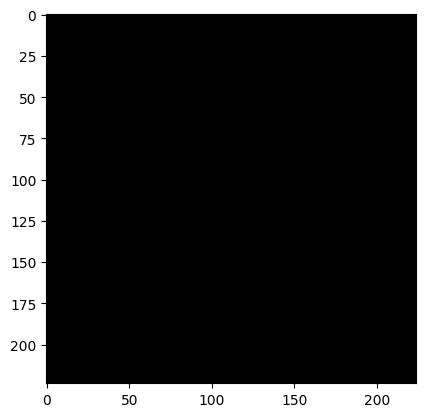

In [33]:
# Plotting some missing masks from the stranger and the fox class
plt.imshow(stranger_masked_tensor_images[stranger_missing_masks[0]])

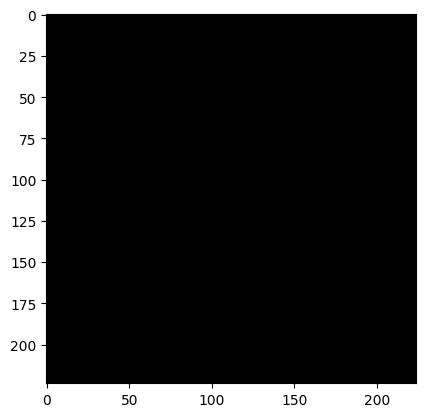

In [34]:
plt.imshow(fox_masked_tensor_images[fox_missing_masks[2]])

In [36]:
# removing the only empty mask image in the stranger class
stranger_masked_tensor_images.pop(stranger_missing_masks[0])
print(f'The class Stranger now has {len(stranger_masked_tensor_images)} images')

The class Stranger now has 147 images


In [37]:
# Removing the four empty masks in the fox class
for _ in range(len(fox_missing_masks)):
    empty_masked_imgs = []
    for idx, masked_img in enumerate(fox_masked_tensor_images):
        # image mask detection validation
        randomlist = random.sample(range(0, 224), 45)
        zeros = torch.zeros([224, 3])
        count = 0
        for i in randomlist:
            if torch.all(masked_img[i] == zeros).item():
                count += 1

        if count == len(randomlist):
            empty_masked_imgs.append(idx)
    if len(empty_masked_imgs) != 0:
        fox_masked_tensor_images.pop(empty_masked_imgs[0])

print(f'The class Fox now has {len(fox_masked_tensor_images)} images')

The class Fox now has 134 images


### Generating extra tensors with augmentation techniques

In [43]:
yuki_enhanched_tensors = generate_extra_tensors(yuki_masked_tensor_images, 1, 224)
sekai_enhanched_tensors = generate_extra_tensors(sekai_masked_tensor_images, 2, 224)
emiko_enhanched_tensors = generate_extra_tensors(emiko_masked_tensor_images, 2, 224)
fox_enhanched_tensors = generate_extra_tensors(fox_masked_tensor_images, 2, 224)
stranger_enhanched_tensors = generate_extra_tensors(stranger_masked_tensor_images, 2, 224)

tensors_dataset = [
    yuki_enhanched_tensors,
    sekai_enhanched_tensors,
    emiko_enhanched_tensors,
    fox_enhanched_tensors,
    stranger_enhanched_tensors
]

for idx, name in enumerate(collections):
    print(f'The class {name} now has {tensors_dataset[idx].shape[0]} tensors')

The class Yuki now has 444 tensors
The class Sekai now has 304 tensors
The class Emiko now has 640 tensors
The class Fox now has 536 tensors
The class Stranger now has 588 tensors


### Generate labels

In [44]:
# Generating labels for each class
emiko_labels = torch.zeros(emiko_enhanched_tensors.shape[0])
yuki_labels = torch.ones(yuki_enhanched_tensors.shape[0])
sekai_labels = torch.full((sekai_enhanched_tensors.shape[0],), 2)
fox_labels = torch.full((fox_enhanched_tensors.shape[0],), 3)
stranger_labels = torch.full((stranger_enhanched_tensors.shape[0],), 4)

In [45]:
# Bind all classes labels and data together
dataset = torch.concat((emiko_enhanched_tensors, yuki_enhanched_tensors, sekai_enhanched_tensors, fox_enhanched_tensors, stranger_enhanched_tensors), dim=0)
labels = torch.concat((emiko_labels, yuki_labels, sekai_labels, fox_labels, stranger_labels), dim=0)

print(f'There are a total of {dataset.shape[0]} tensors in the dataset')

There are a total of 2512 tensors in the dataset


### Split data into training, validation and testing dataset

In [46]:
# Get stratified indices
train_indices, test_indices = create_stratified_split(dataset, labels)

intervals = [
    (0, (emiko_enhanched_tensors.shape[0]-1)), # emiko
    (emiko_enhanched_tensors.shape[0], (emiko_enhanched_tensors.shape[0] + yuki_enhanched_tensors.shape[0]-1)), # yuki
    ((emiko_enhanched_tensors.shape[0] + yuki_enhanched_tensors.shape[0]), (emiko_enhanched_tensors.shape[0] + yuki_enhanched_tensors.shape[0] + sekai_enhanched_tensors.shape[0]-1)), # sekai
    ((emiko_enhanched_tensors.shape[0] + yuki_enhanched_tensors.shape[0] + sekai_enhanched_tensors.shape[0]), (emiko_enhanched_tensors.shape[0] + yuki_enhanched_tensors.shape[0] + sekai_enhanched_tensors.shape[0] + fox_enhanched_tensors.shape[0]-1)), # fox
    ((emiko_enhanched_tensors.shape[0] + yuki_enhanched_tensors.shape[0] + sekai_enhanched_tensors.shape[0] + fox_enhanched_tensors.shape[0]), (dataset.shape[0]-1)) # strangers
]

val_indices = []

for idx, interval in enumerate(intervals):
    start = interval[0]
    end = interval[-1]
    count = 0
    for idx, index in enumerate(train_indices):
        # logic
        whole_count = list(range(start, (end+1)))
        # 100% of the dataset
        tensors_count = len(whole_count)
        # get 20% of the entire dataset
        val_count = (tensors_count // 10) * 2
        if index >= start and index <= end:
            if count == val_count:
                break
            else:
                count += 1
                val_indices.append(index)

# training indices without validation indices
new_train_indices = []
for index in train_indices:
    if index not in val_indices:
        new_train_indices.append(index)

# Alternative approach: creating separate datasets
train_dataset = TensorDataset(
    dataset[new_train_indices], 
    labels[new_train_indices]
)

validation_dataset = TensorDataset(
    dataset[val_indices], 
    labels[val_indices]
)

test_dataset = TensorDataset(
    dataset[test_indices], 
    labels[test_indices]
)

# Verify class distribution in each split
def check_class_distribution(indices, labels):
    subset_labels = labels[indices]
    unique, counts = np.unique(subset_labels, return_counts=True)
    distribution = dict(zip(unique, counts))
    return distribution

train_distribution = check_class_distribution(new_train_indices, labels.numpy())
val_distribution = check_class_distribution(val_indices, labels.numpy())
test_distribution = check_class_distribution(test_indices, labels.numpy())

# Print class distribution
print("Training set class distribution:")
print(check_class_distribution(new_train_indices, labels.numpy()))
print("\nValidation set class distribution:")
print(check_class_distribution(val_indices, labels.numpy()))
print("\nTest set class distribution:")
print(check_class_distribution(test_indices, labels.numpy()))

Training set class distribution:
{0.0: 416, 1.0: 289, 2.0: 198, 3.0: 350, 4.0: 384}

Validation set class distribution:
{0.0: 128, 1.0: 88, 2.0: 60, 3.0: 106, 4.0: 116}

Test set class distribution:
{0.0: 96, 1.0: 67, 2.0: 46, 3.0: 80, 4.0: 88}


In [49]:
# Create new dataloader with updated training data
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=3)
val_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=3)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=BATCH_SIZE, num_workers=3)

## MODEL TRAINING

In [6]:
class_names = [
    'Emiko', 
    'Yuki', 
    'Sekai', 
    'Fox', 
    'Stranger'
]


### EFFICIENT NET

In [11]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
print(auto_transforms)
pt_model = torchvision.models.efficientnet_b0(weights=weights)
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in pt_model.features.parameters():
    param.requires_grad = False

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer
pt_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True))

# Do a summary *after* freezing the features and changing the output classifier layer
architecture = summary(pt_model, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

architecture

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### Training

In [28]:
# Calculate class weights for loss function
class_counts = torch.tensor([train_distribution[0],
                            train_distribution[1],
                            train_distribution[2],
                            train_distribution[3],
                            train_distribution[4]])
total_samples = class_counts.sum()
class_weights = total_samples / (5 * class_counts)

# Use weighted cross-entropy loss
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

In [29]:
# Initialise empty list to store accuracy and loss of all the next models
transfer_learning_model_results = []

In [62]:
pt_model_0 = train_tl_model(0.00001, 
                            10, 
                            train_dataloader, 
                            val_dataloader, 
                            class_names, 
                            transfer_learning_model_results,
                            pt_model,
                            loss_fn)

Epoch: 00 | Train loss: 1.6026, Train acc: 0.23% | Test loss: 1.5832, Test acc: 0.21%
Epoch: 01 | Train loss: 1.5743, Train acc: 0.27% | Test loss: 1.5499, Test acc: 0.31%
Epoch: 02 | Train loss: 1.5426, Train acc: 0.33% | Test loss: 1.5181, Test acc: 0.38%
Epoch: 03 | Train loss: 1.5119, Train acc: 0.37% | Test loss: 1.4850, Test acc: 0.46%
Epoch: 04 | Train loss: 1.4906, Train acc: 0.43% | Test loss: 1.4597, Test acc: 0.53%
Epoch: 05 | Train loss: 1.4570, Train acc: 0.49% | Test loss: 1.4271, Test acc: 0.57%
Epoch: 06 | Train loss: 1.4290, Train acc: 0.53% | Test loss: 1.3959, Test acc: 0.61%
Epoch: 07 | Train loss: 1.4020, Train acc: 0.56% | Test loss: 1.3804, Test acc: 0.63%
Epoch: 08 | Train loss: 1.3812, Train acc: 0.58% | Test loss: 1.3477, Test acc: 0.66%
Epoch: 09 | Train loss: 1.3570, Train acc: 0.63% | Test loss: 1.3200, Test acc: 0.70%


In [68]:
pt_model_1 = train_tl_model(0.0001, 
                            10, 
                            train_dataloader, 
                            val_dataloader, 
                            class_names, 
                            transfer_learning_model_results,
                            pt_model,
                            loss_fn)

Epoch: 00 | Train loss: 1.2330, Train acc: 0.73% | Test loss: 1.0807, Test acc: 0.82%
Epoch: 01 | Train loss: 1.0402, Train acc: 0.83% | Test loss: 0.9144, Test acc: 0.89%
Epoch: 02 | Train loss: 0.8784, Train acc: 0.89% | Test loss: 0.7699, Test acc: 0.92%
Epoch: 03 | Train loss: 0.7650, Train acc: 0.92% | Test loss: 0.6508, Test acc: 0.93%
Epoch: 04 | Train loss: 0.6823, Train acc: 0.92% | Test loss: 0.5727, Test acc: 0.94%
Epoch: 05 | Train loss: 0.6031, Train acc: 0.93% | Test loss: 0.5103, Test acc: 0.94%
Epoch: 06 | Train loss: 0.5348, Train acc: 0.95% | Test loss: 0.4570, Test acc: 0.96%
Epoch: 07 | Train loss: 0.4876, Train acc: 0.95% | Test loss: 0.4078, Test acc: 0.96%
Epoch: 08 | Train loss: 0.4532, Train acc: 0.95% | Test loss: 0.3830, Test acc: 0.96%
Epoch: 09 | Train loss: 0.4198, Train acc: 0.94% | Test loss: 0.3406, Test acc: 0.96%


In [110]:
pt_model_2 = train_tl_model(0.00005, 
                            20, 
                            train_dataloader, 
                            val_dataloader, 
                            class_names, 
                            transfer_learning_model_results,
                            pt_model,
                            loss_fn)

Epoch: 00 | Train loss: 0.3955, Train acc: 0.95% | Test loss: 0.3282, Test acc: 0.96%
Epoch: 01 | Train loss: 0.3691, Train acc: 0.96% | Test loss: 0.3030, Test acc: 0.96%
Epoch: 02 | Train loss: 0.3528, Train acc: 0.96% | Test loss: 0.2863, Test acc: 0.96%
Epoch: 03 | Train loss: 0.3365, Train acc: 0.96% | Test loss: 0.2744, Test acc: 0.96%
Epoch: 04 | Train loss: 0.3172, Train acc: 0.96% | Test loss: 0.2699, Test acc: 0.96%
Epoch: 05 | Train loss: 0.3065, Train acc: 0.96% | Test loss: 0.2612, Test acc: 0.96%
Epoch: 06 | Train loss: 0.3098, Train acc: 0.95% | Test loss: 0.2424, Test acc: 0.96%
Epoch: 07 | Train loss: 0.2851, Train acc: 0.97% | Test loss: 0.2401, Test acc: 0.96%
Epoch: 08 | Train loss: 0.2726, Train acc: 0.96% | Test loss: 0.2277, Test acc: 0.96%
Epoch: 09 | Train loss: 0.2676, Train acc: 0.96% | Test loss: 0.2134, Test acc: 0.96%
Epoch: 10 | Train loss: 0.2547, Train acc: 0.96% | Test loss: 0.2083, Test acc: 0.97%
Epoch: 11 | Train loss: 0.2508, Train acc: 0.96% | Tes

### Accuracy and loss curves

Best test accuracy: 0.70%


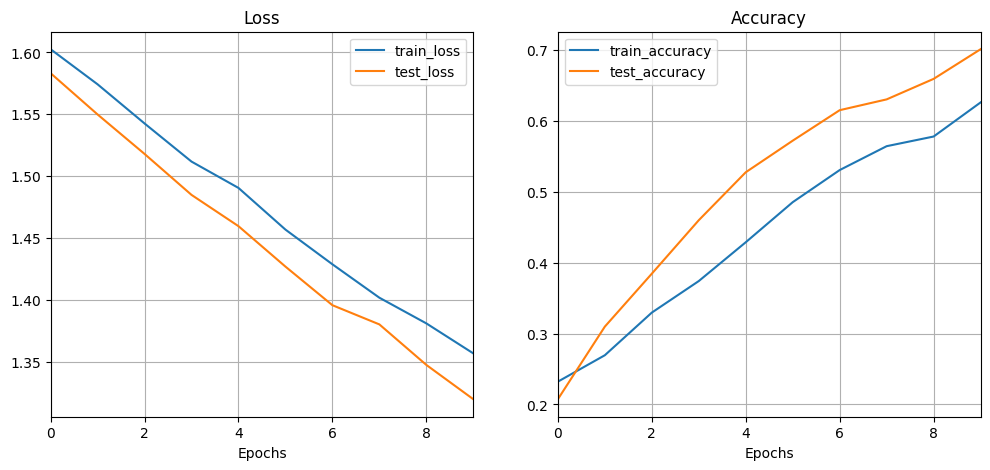

In [63]:
plot_tl_loss_curves(transfer_learning_model_results[0])

Best test accuracy: 0.96%


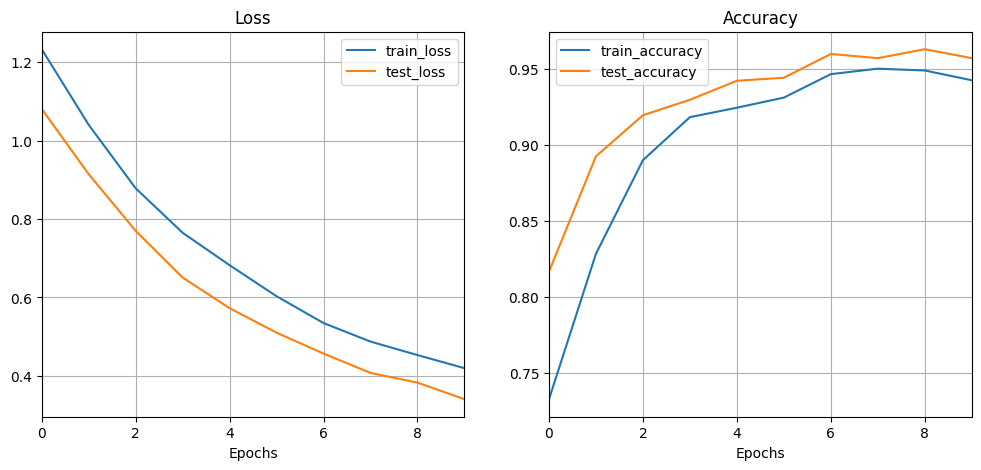

In [69]:
plot_tl_loss_curves(transfer_learning_model_results[1])

Best test accuracy: 0.97%


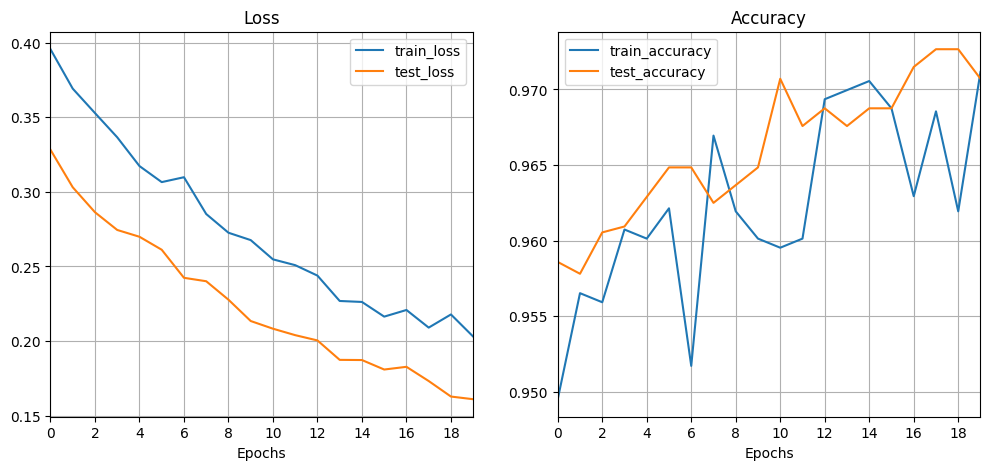

In [111]:
plot_tl_loss_curves(transfer_learning_model_results[2])

### Precision per class

In [64]:
get_model_accuracy(pt_model_0, test_dataloader, class_names)

Precision per class:
Emiko: 73.33%
Yuki: 68.92%
Sekai: 52.50%
Fox: 88.61%
Stranger: 84.00%
Macro-average precision: 73.47%
Weighted-average precision: 75.76%


In [70]:
get_model_accuracy(pt_model_1, test_dataloader, class_names)

Precision per class:
Emiko: 92.23%
Yuki: 97.06%
Sekai: 95.83%
Fox: 98.77%
Stranger: 97.44%
Macro-average precision: 96.27%
Weighted-average precision: 96.13%


In [112]:
get_model_accuracy(pt_model_2, test_dataloader, class_names)

Precision per class:
Emiko: 95.96%
Yuki: 100.00%
Sekai: 95.83%
Fox: 97.56%
Stranger: 97.59%
Macro-average precision: 97.39%
Weighted-average precision: 97.38%


## MODEL EVALUATION

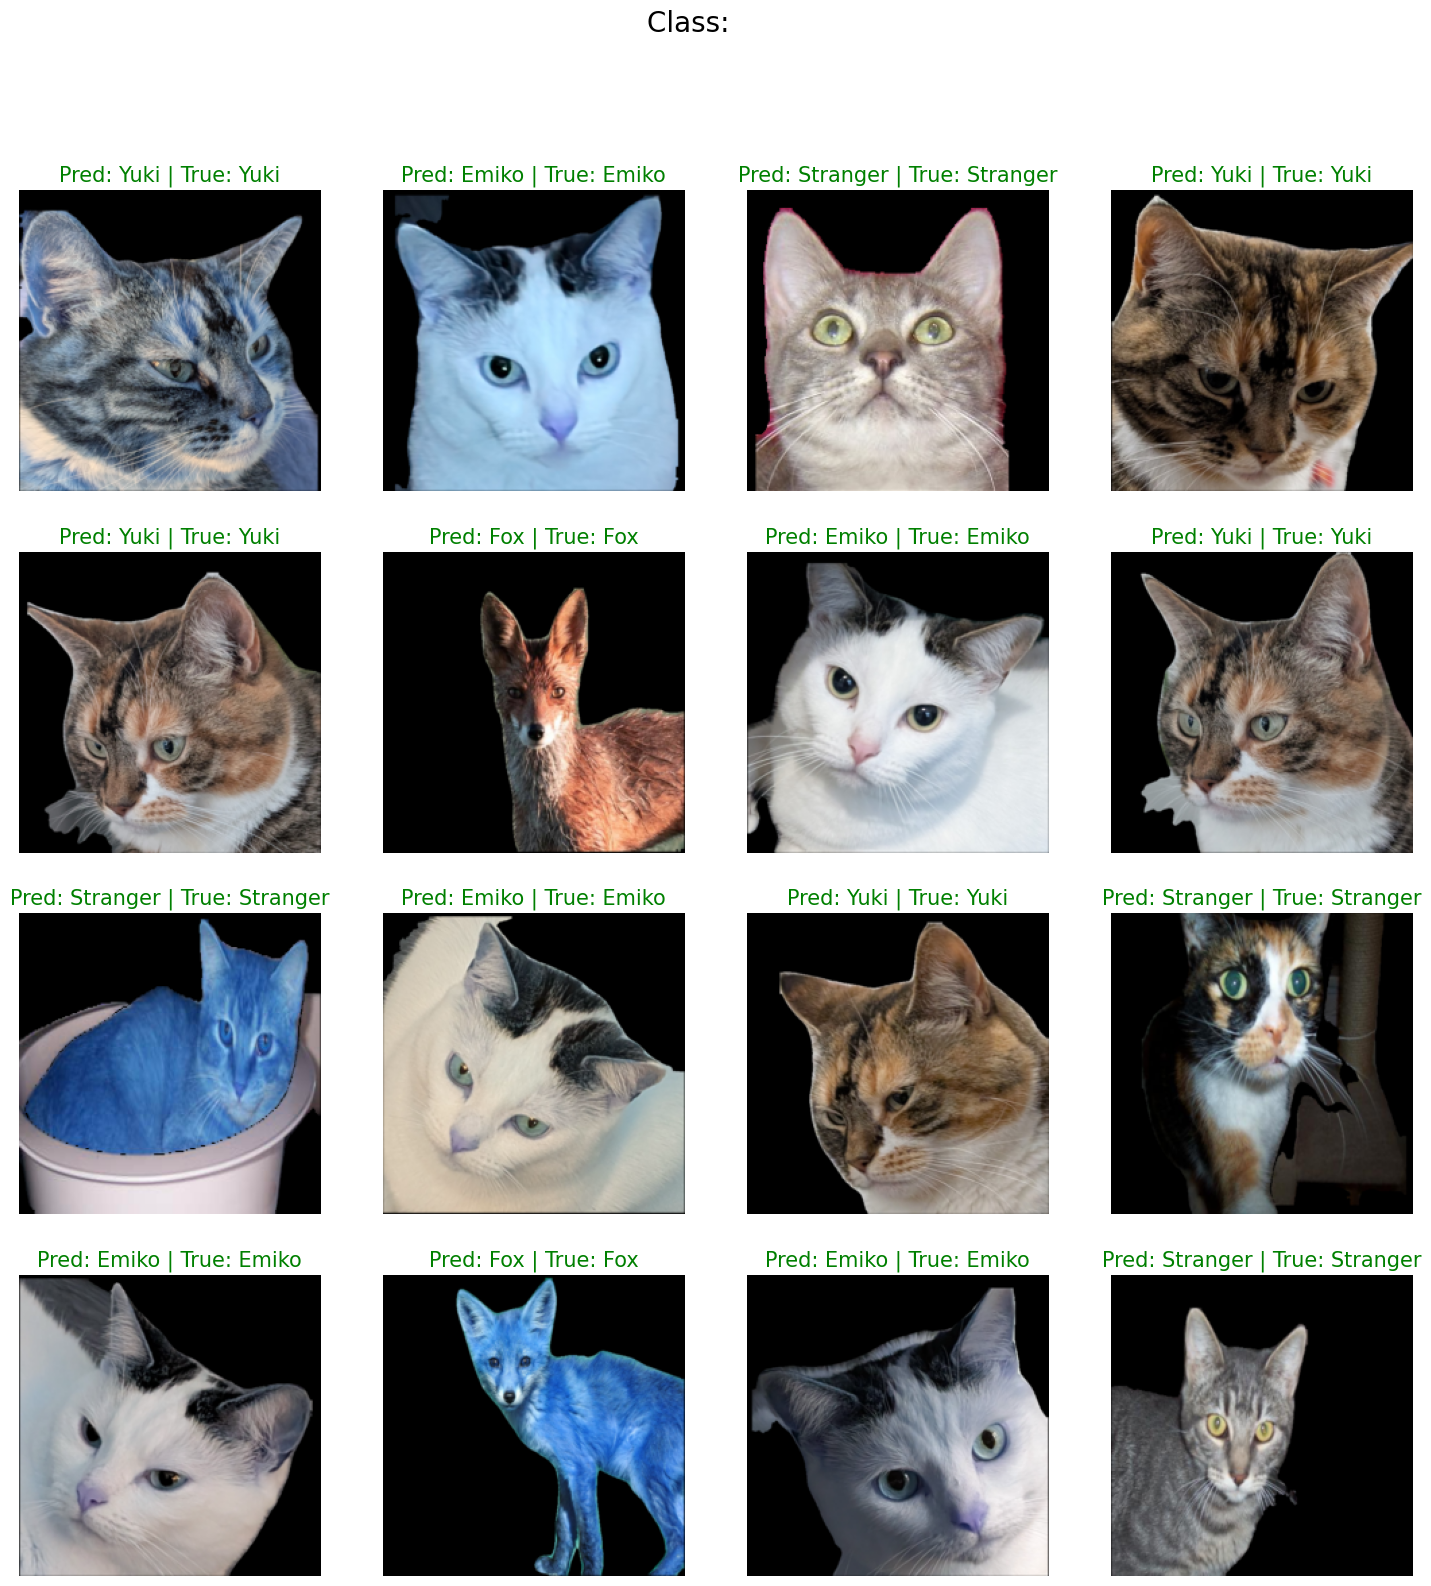

In [109]:
predictions = eval_model(test_dataloader, pt_model_1, class_names)

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

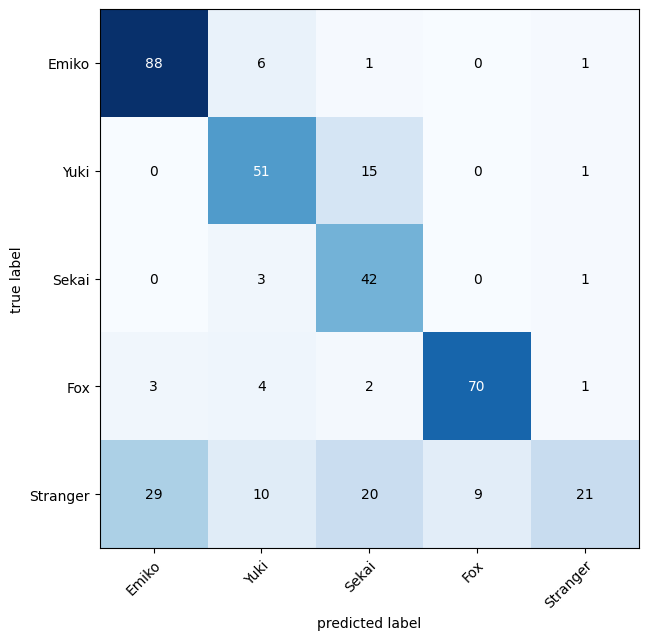

In [67]:
generate_confmat(pt_model_0, test_dataloader, class_names)

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

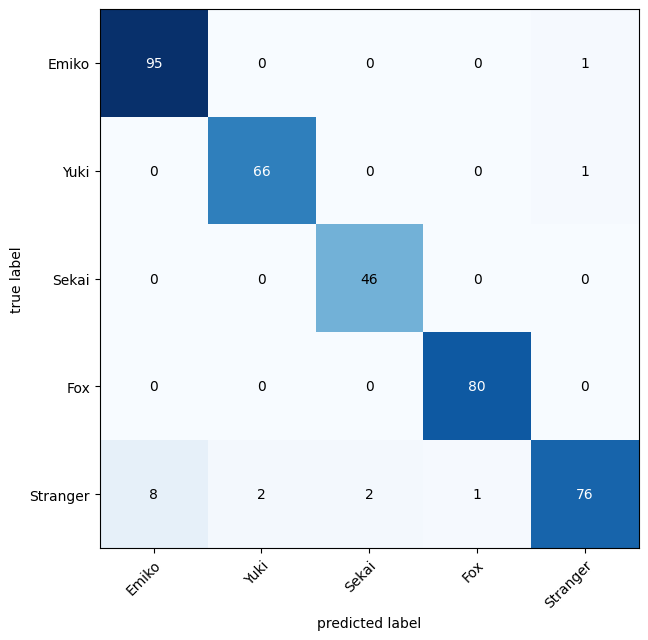

In [71]:
generate_confmat(pt_model_1, test_dataloader, class_names)

(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

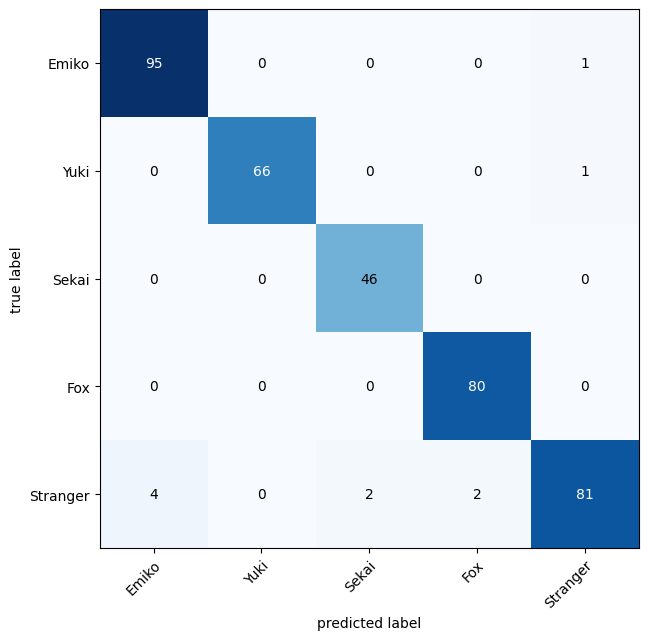

In [113]:
generate_confmat(pt_model_2, test_dataloader, class_names)